In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [182]:
df = pd.read_csv('loan_data_2007_2014.csv', index_col=0, dtype = {'desc' : str})

In [183]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [185]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [186]:
df.loan_status.value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [187]:
df['loan_status_enc'] = np.where(df.loc[:, 'loan_status'].isin(['Charged Off', 'Late (31-120 days)', 'Default', 'Does not meet the credit policy. Status:Charged Off']), 0, 1)
print(df['loan_status_enc'])

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: loan_status_enc, Length: 466285, dtype: int32


In [188]:
df['loan_status_enc'].value_counts(normalize=True)*100

1    89.069346
0    10.930654
Name: loan_status_enc, dtype: float64

In [189]:
todate = pd.to_datetime('2017-07-30')
def date_columns(df, column):
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    df['mths_since_' + column] = round(pd.to_numeric((todate - df[column]) / np.timedelta64(1, 'M')))
    df['mths_since_' + column] = df['mths_since_' + column].apply( lambda x: df['mths_since_' + column].max() if x < 0 else x)
    df.drop(columns = [column], inplace = True)
    
date_columns(df, 'earliest_cr_line')
print(df['mths_since_earliest_cr_line'])
print(df['mths_since_earliest_cr_line'].describe())

0         391.0
1         220.0
2         189.0
3         258.0
4         259.0
          ...  
466280    172.0
466281    242.0
466282    188.0
466283    174.0
466284    210.0
Name: mths_since_earliest_cr_line, Length: 466285, dtype: float64
count    466256.000000
mean        238.385374
std          86.460310
min          69.000000
25%         180.000000
50%         222.000000
75%         281.000000
max         583.000000
Name: mths_since_earliest_cr_line, dtype: float64


In [190]:
print('mths_since_issued')
date_columns(df, 'issue_d')
print(df['mths_since_issue_d'])
print(df['mths_since_issue_d'].describe())


print('mths_since_last_credit_pull_d')
date_columns(df, 'last_credit_pull_d')
print(df['mths_since_last_credit_pull_d'])
print(df['mths_since_last_credit_pull_d'].describe())


print('mths_since_last_pymnt_d')
date_columns(df, 'last_pymnt_d')
print(df['mths_since_last_pymnt_d'])
print(df['mths_since_last_pymnt_d'].describe())


print('mths_since_next_pymnt_d')
date_columns(df, 'next_pymnt_d')
print(df['mths_since_next_pymnt_d'])
print(df['mths_since_next_pymnt_d'].describe())

mths_since_issued
0         68.0
1         68.0
2         68.0
3         68.0
4         68.0
          ... 
466280    43.0
466281    43.0
466282    43.0
466283    43.0
466284    43.0
Name: mths_since_issue_d, Length: 466285, dtype: float64
count    466285.000000
mean         47.255187
std          14.340154
min          32.000000
25%          37.000000
50%          43.000000
75%          53.000000
max         122.000000
Name: mths_since_issue_d, dtype: float64
mths_since_last_credit_pull_d
0         19.0
1         47.0
2         19.0
3         31.0
4         19.0
          ... 
466280    19.0
466281    19.0
466282    20.0
466283    28.0
466284    19.0
Name: mths_since_last_credit_pull_d, Length: 466285, dtype: float64
count    466243.000000
mean         23.045588
std           9.636423
min          19.000000
25%          19.000000
50%          19.000000
75%          21.000000
max         123.000000
Name: mths_since_last_credit_pull_d, dtype: float64
mths_since_last_pymnt_d
0         31

In [191]:
df['term'] = df.term.str.replace(' months', '', regex=True)
df['term'] = pd.to_numeric(df['term'])
print(df['term'])

0         36
1         60
2         36
3         36
4         60
          ..
466280    60
466281    60
466282    60
466283    36
466284    36
Name: term, Length: 466285, dtype: int64


In [192]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [193]:
df['emp_length_int'] = df['emp_length'].str.replace('\+ years', '', regex=True)
df['emp_length_int'] = df['emp_length_int'].str.replace('< 1 year', str(0), regex=True)
df['emp_length_int'] = df['emp_length_int'].str.replace(' years', '', regex=True)
df['emp_length_int'] = df['emp_length_int'].str.replace(' year', '', regex=True)

df['emp_length_int'] = pd.to_numeric(df["emp_length_int"], downcast="float")
print(df['emp_length_int'].dtypes)

float32


In [194]:
df['emp_length_int'].value_counts()

10.0    150049
2.0      41373
3.0      36596
0.0      36265
5.0      30774
1.0      29622
4.0      28023
7.0      26180
6.0      26112
8.0      22395
9.0      17888
Name: emp_length_int, dtype: int64

In [195]:
df.select_dtypes(include='object').nunique()

grade                       7
sub_grade                  35
emp_title              205475
emp_length                 11
home_ownership              6
verification_status         3
loan_status                 9
pymnt_plan                  2
url                    466285
desc                   124436
purpose                    14
title                   63099
zip_code                  888
addr_state                 50
initial_list_status         2
application_type            1
dtype: int64

In [196]:
df.drop(['sub_grade', 'emp_title', 'pymnt_plan', 'url', 'desc', 'title', 'zip_code', 'addr_state', 'application_type'],axis=1, inplace=True)

In [197]:
col_drop = df.dropna(thresh = df.shape[0]*0.2, how = 'all', axis = 1, inplace = True)
print(col_drop)

None


<AxesSubplot:>

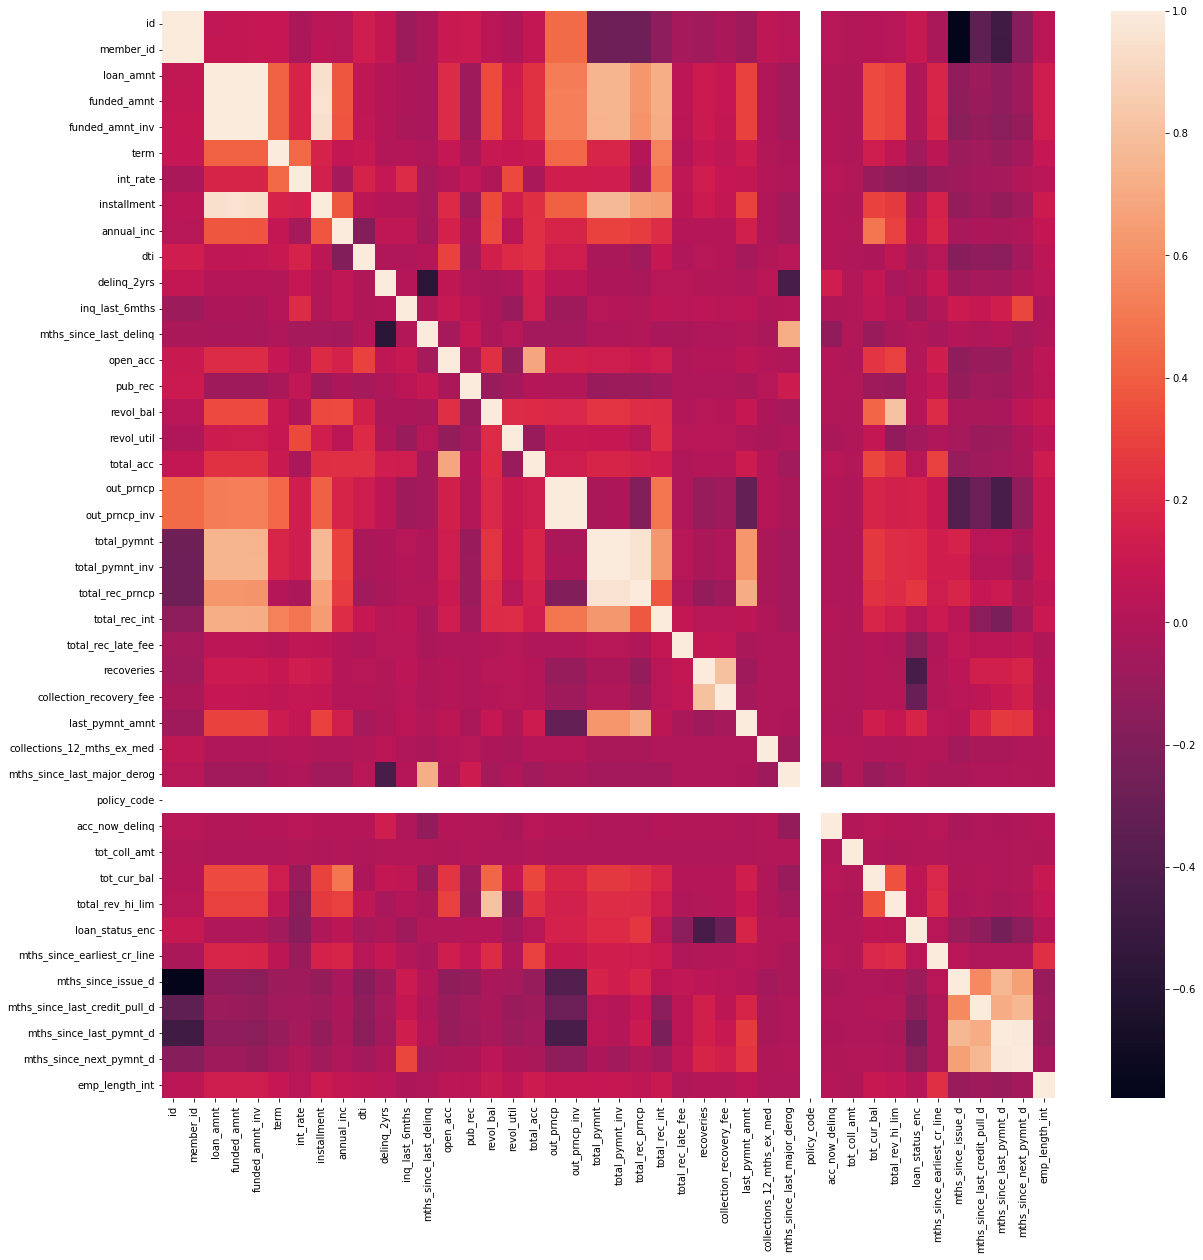

In [198]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())

In [199]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_hicorr = [column for column in upper.columns if any(upper[column] > 0.7)]

C:\Users\User\AppData\Local\Temp\ipykernel_17244\2772442783.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [200]:
to_drop_hicorr

['member_id',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'mths_since_last_major_derog',
 'total_rev_hi_lim',
 'mths_since_issue_d',
 'mths_since_last_pymnt_d',
 'mths_since_next_pymnt_d']

In [201]:
df.drop(to_drop_hicorr, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             466285 non-null  int64  
 1   loan_amnt                      466285 non-null  int64  
 2   term                           466285 non-null  int64  
 3   int_rate                       466285 non-null  float64
 4   grade                          466285 non-null  object 
 5   emp_length                     445277 non-null  object 
 6   home_ownership                 466285 non-null  object 
 7   annual_inc                     466281 non-null  float64
 8   verification_status            466285 non-null  object 
 9   loan_status                    466285 non-null  object 
 10  purpose                        466285 non-null  object 
 11  dti                            466285 non-null  float64
 12  delinq_2yrs                   

In [202]:
df.fillna(0, inplace=True)

In [203]:
df.drop(['loan_status'], axis=1, inplace=True)

In [204]:
df.drop(['id'], axis=1, inplace=True)

In [205]:
categorical_cols = [col for col in df.select_dtypes(include='object').columns.tolist()]

In [206]:
onehot = pd.get_dummies(df[categorical_cols], drop_first=True)

In [207]:
onehot.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [208]:
chi2_check = {}

In [209]:
from scipy.stats import chi2_contingency


for column in onehot:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(df['loan_status_enc'], onehot[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

In [210]:
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

In [211]:
chi2_result

,Feature,p-value
0,grade_B,0.000000e+00
1,purpose_small_business,0.000000e+00
2,purpose_other,0.000000e+00
3,purpose_moving,0.000000e+00
4,purpose_debt_consolidation,0.000000e+00
5,purpose_credit_card,0.000000e+00
6,verification_status_Verified,0.000000e+00
7,verification_status_Source Verified,0.000000e+00
8,home_ownership_RENT,0.000000e+00
9,home_ownership_MORTGAGE,0.000000e+00


In [212]:
num_col = [col for col in df.columns.tolist() if col not in categorical_cols + ['loan_status_enc']]

In [213]:
ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(df[num_col]), columns=num_col)

In [214]:
std.head()

,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,...,total_rec_late_fee,recoveries,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_earliest_cr_line,mths_since_last_credit_pull_d,emp_length_int
0,-1.124392,-0.616225,-0.729587,-0.896533,1.328632,-0.357012,0.178920,-0.700148,-1.641166,-0.31429,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.792648,1.764952,-0.419518,1.138605
1,-1.426088,1.622784,0.330634,-0.787370,-2.065791,-0.357012,3.843328,-0.700148,-1.641166,-0.31429,...,-0.123464,0.057470,-0.083608,0.0,-0.058307,-0.012089,-0.792648,-0.212430,2.485510,-1.523744
2,-1.438156,-0.616225,0.488979,-1.110274,-1.082491,-0.357012,1.095022,-0.700148,-1.841641,-0.31429,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.792648,-0.570903,-0.419518,1.138605
3,-0.521001,-0.616225,-0.077850,-0.438048,0.354248,-0.357012,0.178920,0.851444,-0.237839,-0.31429,...,3.099264,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.792648,0.226988,0.825494,1.138605
4,-1.365749,1.622784,-0.261438,0.122322,0.091865,-0.357012,-0.737182,0.984438,0.764538,-0.31429,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.792648,0.238552,-0.419518,-1.257509


In [215]:
df_model = pd.concat([onehot, std, df[['loan_status_enc']]], axis=1)

In [216]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 63 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   grade_B                              466285 non-null  uint8  
 1   grade_C                              466285 non-null  uint8  
 2   grade_D                              466285 non-null  uint8  
 3   grade_E                              466285 non-null  uint8  
 4   grade_F                              466285 non-null  uint8  
 5   grade_G                              466285 non-null  uint8  
 6   emp_length_1 year                    466285 non-null  uint8  
 7   emp_length_10+ years                 466285 non-null  uint8  
 8   emp_length_2 years                   466285 non-null  uint8  
 9   emp_length_3 years                   466285 non-null  uint8  
 10  emp_length_4 years                   466285 non-null  uint8  
 11  emp_length_5 

In [217]:
df_model.sample(5)

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,...,recoveries,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_earliest_cr_line,mths_since_last_credit_pull_d,emp_length_int,loan_status_enc
7193,1,0,0,0,0,0,0,0,0,0,...,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.792648,-0.501521,-0.004514,0.339900,1
312517,1,0,0,0,0,0,0,0,0,0,...,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.489453,-0.409012,-0.419518,-1.523744,1
145808,0,1,0,0,0,0,0,0,0,0,...,1.520214,-0.083608,0.0,-0.058307,-0.012089,-0.670768,-1.334103,1.759253,-1.523744,0
278870,0,1,0,0,0,0,0,0,0,0,...,-0.154549,-0.083608,0.0,-0.058307,-0.012089,0.982970,0.065097,-0.419518,-1.523744,1
36343,0,1,0,0,0,0,0,0,0,1,...,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.792648,0.331061,-0.419518,-0.725040,0


In [218]:
X = df_model.drop('loan_status_enc', axis = 1)
y = df_model['loan_status_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train, X_test = X_train.copy(), X_test.copy()

In [219]:
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279771 entries, 153181 to 121958
Data columns (total 62 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   grade_B                              279771 non-null  uint8  
 1   grade_C                              279771 non-null  uint8  
 2   grade_D                              279771 non-null  uint8  
 3   grade_E                              279771 non-null  uint8  
 4   grade_F                              279771 non-null  uint8  
 5   grade_G                              279771 non-null  uint8  
 6   emp_length_1 year                    279771 non-null  uint8  
 7   emp_length_10+ years                 279771 non-null  uint8  
 8   emp_length_2 years                   279771 non-null  uint8  
 9   emp_length_3 years                   279771 non-null  uint8  
 10  emp_length_4 years                   279771 non-null  uint8  
 11  emp_leng

In [220]:
rfc = RandomForestClassifier(max_depth=4)
rfc.fit(X_test, y_test)

RandomForestClassifier(max_depth=4)

In [221]:
X_train

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,...,total_rec_late_fee,recoveries,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_earliest_cr_line,mths_since_last_credit_pull_d,emp_length_int
153181,0,0,1,0,0,0,0,0,0,0,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.699890,0.307933,-0.419518,0.339900
192444,0,0,0,0,0,0,0,0,0,0,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.602142,-1.218467,0.929245,-0.192570
24090,0,0,1,0,0,0,0,0,1,0,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.792648,-0.362758,-0.419518,-0.991274
437550,0,0,0,0,0,0,0,0,0,0,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.453829,-0.859994,-0.419518,-1.523744
317027,1,0,0,0,0,0,0,1,0,0,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,0.289012,1.614625,-0.419518,1.138605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1,0,0,0,0,0,0,0,0,1,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,0.125716,-0.074383,0.319497,-0.419518,-0.725040
365838,1,0,0,0,0,0,0,1,0,0,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.644268,-0.848431,-0.419518,1.138605
131932,1,0,0,0,0,0,0,1,0,0,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,-0.686576,-0.964067,-0.419518,1.138605
146867,1,0,0,0,0,0,0,1,0,0,...,-0.123464,-0.154549,-0.083608,0.0,-0.058307,-0.012089,1.081087,0.099788,-0.419518,1.138605


In [222]:
arr_feature_importances = rfc.feature_importances_
arr_feature_names = X_train.columns.values
    
df_feature_importance = pd.DataFrame(index=range(len(arr_feature_importances)), columns=['feature', 'importance'])
df_feature_importance['feature'] = arr_feature_names
df_feature_importance['importance'] = arr_feature_importances
df_all_features = df_feature_importance.sort_values(by='importance', ascending=False)
df_all_features

,feature,importance
53,recoveries,0.497736
51,out_prncp,0.171482
52,total_rec_late_fee,0.088780
60,mths_since_last_credit_pull_d,0.068343
40,int_rate,0.067849
...,...,...
18,home_ownership_NONE,0.000000
55,policy_code,0.000000
35,purpose_vacation,0.000000
27,purpose_home_improvement,0.000000


In [223]:
X_train1 = X_train.iloc[:, [42, 40, 41, 29, 49, 4, 28, 2, 3, 0, 30, 47, 33, 31, 23, 26, 12, 27, 5, 10, 6, 1, 48, 39, 50]]
print(X_train1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279771 entries, 153181 to 121958
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   dti                           279771 non-null  float64
 1   int_rate                      279771 non-null  float64
 2   annual_inc                    279771 non-null  float64
 3   purpose_major_purchase        279771 non-null  uint8  
 4   revol_util                    279771 non-null  float64
 5   grade_F                       279771 non-null  uint8  
 6   purpose_house                 279771 non-null  uint8  
 7   grade_D                       279771 non-null  uint8  
 8   grade_E                       279771 non-null  uint8  
 9   grade_B                       279771 non-null  uint8  
 10  purpose_medical               279771 non-null  uint8  
 11  pub_rec                       279771 non-null  float64
 12  purpose_renewable_energy      279771 no

In [226]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 186514 entries, 362514 to 204275
Series name: loan_status_enc
Non-Null Count   Dtype
--------------   -----
186514 non-null  int32
dtypes: int32(1)
memory usage: 2.1 MB


In [227]:
lr = LogisticRegression()
lr.fit(X_test, y_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [228]:
y_predict = lr.predict(X_test)

In [229]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
a1 = accuracy_score(y_test,y_predict)
f1 = f1_score(y_test, y_predict, average="macro")
p1 = precision_score(y_test, y_predict, average="macro")
r1 = recall_score(y_test, y_predict, average="macro")
print("accuracy score : ",a1)
print("f1 score : ",f1)
print("precision score : ",p1)
print("recall score : ",r1)

accuracy score :  0.9386641217281276
f1 score :  0.7934246143821767
precision score :  0.9580061017755515
recall score :  0.7262898852939194


In [164]:
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index
print(df_actual_predicted)

        y_actual  y_pred_proba
362514         1      0.897877
288564         1      0.907943
213591         1      0.899532
263083         1      0.940328
165001         1      0.914779
...          ...           ...
309645         1      0.944281
349139         1      0.932860
430405         1      0.948803
431652         1      0.867350
204275         1      0.898982

[186514 rows x 2 columns]


In [165]:
from sklearn.metrics import roc_curve, roc_auc_score

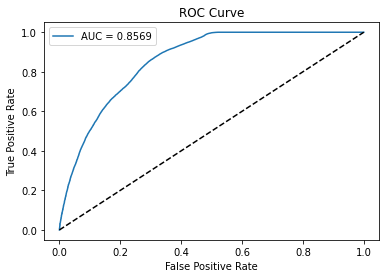

In [166]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

In [167]:
logit_roc_auc = roc_auc_score(y_test, y_predict)

print(logit_roc_auc)

0.7262898852939194


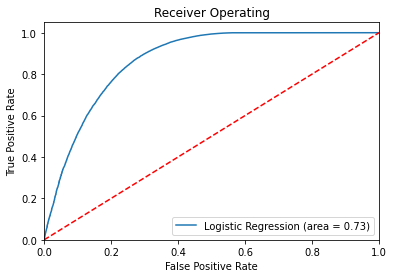

In [168]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [169]:
df_actual_predicted = df_actual_predicted.sort_values('y_pred_proba')
df_actual_predicted = df_actual_predicted.reset_index()

df_actual_predicted['Cumulative N Population'] = df_actual_predicted.index + 1
df_actual_predicted['Cumulative N Bad'] = df_actual_predicted['y_actual'].cumsum()
df_actual_predicted['Cumulative N Good'] = df_actual_predicted['Cumulative N Population'] - df_actual_predicted['Cumulative N Bad']
df_actual_predicted['Cumulative Perc Population'] = df_actual_predicted['Cumulative N Population'] / df_actual_predicted.shape[0]
df_actual_predicted['Cumulative Perc Bad'] = df_actual_predicted['Cumulative N Bad'] / df_actual_predicted['y_actual'].sum()
df_actual_predicted['Cumulative Perc Good'] = df_actual_predicted['Cumulative N Good'] / (df_actual_predicted.shape[0] - df_actual_predicted['y_actual'].sum())

Text(0.5, 1.0, 'Kolmogorov-Smirnov:  0.5600')

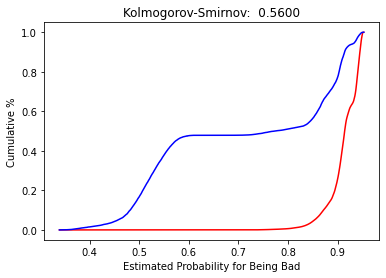

In [170]:
KS = max(df_actual_predicted['Cumulative Perc Good'] - df_actual_predicted['Cumulative Perc Bad'])

plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Bad'], color='r')
plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Good'], color='b')
plt.xlabel('Estimated Probability for Being Bad')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov:  %0.4f' %KS)

In [171]:
X_test = X_test.iloc[:, [42, 40, 41, 29, 49, 4, 28, 2, 3, 0, 30, 47, 33, 31, 23, 26, 12, 27, 5, 10, 6, 1, 48, 39, 50]]
print(X_test.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 186514 entries, 362514 to 204275
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   dti                           186514 non-null  float64
 1   int_rate                      186514 non-null  float64
 2   annual_inc                    186514 non-null  float64
 3   purpose_major_purchase        186514 non-null  uint8  
 4   revol_util                    186514 non-null  float64
 5   grade_F                       186514 non-null  uint8  
 6   purpose_house                 186514 non-null  uint8  
 7   grade_D                       186514 non-null  uint8  
 8   grade_E                       186514 non-null  uint8  
 9   grade_B                       186514 non-null  uint8  
 10  purpose_medical               186514 non-null  uint8  
 11  pub_rec                       186514 non-null  float64
 12  purpose_renewable_energy      186514 no

In [172]:
X_train, y_train = make_classification(n_samples=279771 ,n_features=51,random_state=1)
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=25)
rfe.fit(X_train, y_train)
print(rfe)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=25)


In [ ]:
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 3.000
Column: 1, Selected False, Rank: 9.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 11.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected False, Rank: 8.000
Column: 7, Selected False, Rank: 22.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 25.000
Column: 11, Selected False, Rank: 12.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected False, Rank: 24.000
Column: 15, Selected False, Rank: 19.000
Column: 16, Selected False, Rank: 20.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected False, Rank: 10.000
Column: 19, Selected False, Rank: 27.000
Column: 20, Selected False, Rank: 23.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected False, Rank: 15.000
Column: 23, Selected True, Rank: 1.000
Column: 24, Selected False, Rank: 6.000
Column: 2

IndexError: index 51 is out of bounds for axis 0 with size 51